https://www.kaggle.com/datasets/mrsohelrana/bank-marketing-data данные

__bank client data:__

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

__related with the last contact of the current campaign:__

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

__other attributes:__

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

__Output variable (desired target):__

16 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
import shap
import xgboost
import dill

f:\anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Посмотрим на данные

1 - Возраст

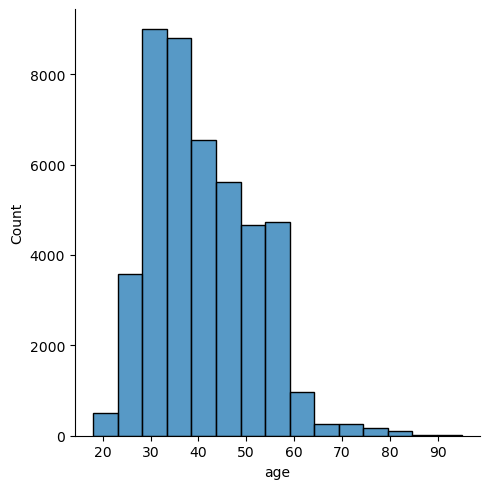

In [4]:
sns.displot(df, x='age', bins=15)

Выбросов нет, можно работать.

2 - работа

In [5]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

3 - семейное положение

In [6]:
df['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

4 - образование

In [7]:
df['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

5 - Наличие кредита

In [8]:
df['default'].value_counts()

no     44396
yes      815
Name: default, dtype: int64

6 - Баланс

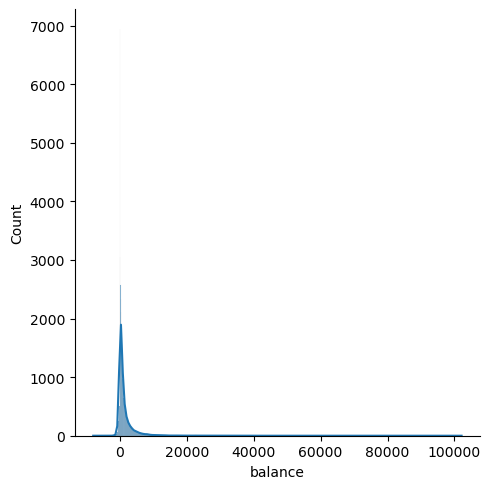

In [9]:
sns.displot(df, x='balance', kde=True)
plt.show()

Имеются выбросы и видимо отрицательные значения. Нужна проверка

In [10]:
df['balance'].min()

-8019

In [11]:
df['balance'].max()

102127

In [12]:
df[df['balance'] > 100000].value_counts()

age  job         marital  education  default  balance  housing  loan  contact   day  month  duration  campaign  pdays  previous  poutcome  y 
51   management  single   tertiary   no       102127   no       no    cellular  3    jun    90        1         -1     0         unknown   no    1
dtype: int64

In [13]:
df[df['balance'] < -200].value_counts()

age  job         marital  education  default  balance  housing  loan  contact   day  month  duration  campaign  pdays  previous  poutcome  y  
20   student     single   secondary  no       -322     yes      no    unknown   20   jun    73        4         -1     0         unknown   no     1
43   management  married  tertiary   no       -391     yes      no    cellular  28   jul    193       8         -1     0         unknown   no     1
44   admin.      married  secondary  no       -314     no       no    cellular  18   may    144       3         -1     0         unknown   no     1
                                              -372     yes      no    unknown   5    may    172       1         -1     0         unknown   no     1
43   technician  single   secondary  no       -266     yes      yes   cellular  15   may    12        5         -1     0         unknown   no     1
                                                                                                                     

Можно предположить, что с полем "balance" проблем нет, он может быть отрицательным и выброс в нем тоже не аномалия.

7 - Домовладение

In [14]:
df['housing'].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

8 - Наличие кредита

In [15]:
df['loan'].value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

9 - Вид связи

In [16]:
df['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

10 - День месяца, в который клиент был последний раз на связи

In [17]:
df['day'].min()

1

In [18]:
df['day'].max()

31

Аномалий по дням нет, смотрим дальше.

11 - Месяц, в который клиент был последний раз на связи

In [19]:
df['month'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

12 - Длительность разговора в секундах

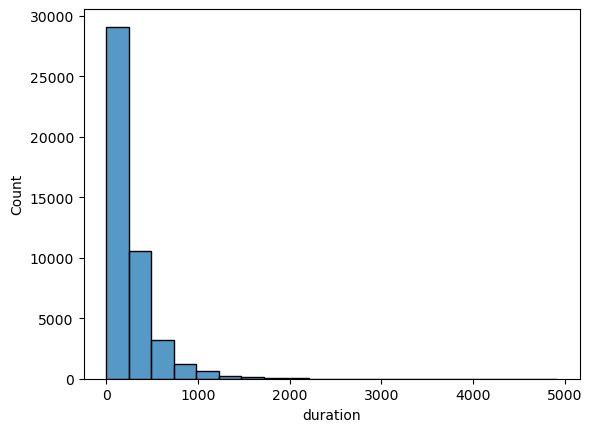

In [20]:
sns.histplot(data=df, x='duration', bins=20)
plt.show()

13 - Количество контактов (звонков) с этим клиентом в течении этой маркетинговой компании (включая последний звонок)

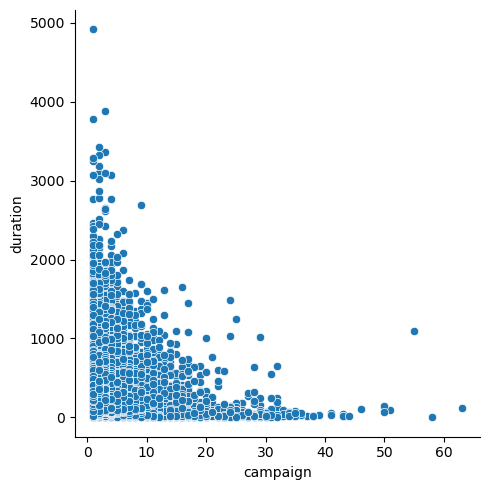

In [21]:
sns.relplot(data=df, x="campaign", y="duration")
plt.show()

Можно сделать вывод, что чем чаще звонит банк, тем короче становятся разговоры :)

14 -  pdays: количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании (numeric; 999 means client was not previously contacted)

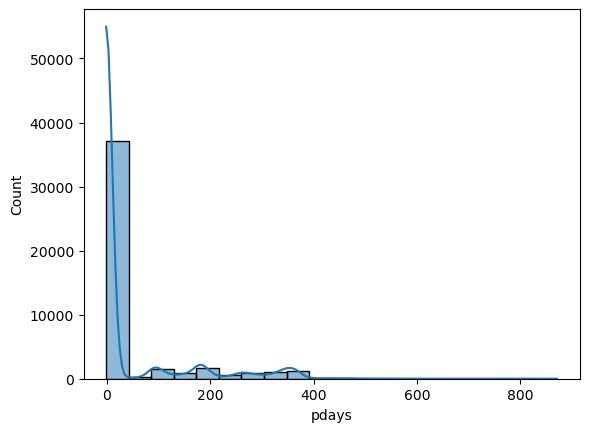

In [22]:
sns.histplot(data=df, x='pdays', bins=20, kde=True)
plt.show()

In [23]:
df['pdays'].max()

871

15 - previous: количество контактов с клиентом, проводимых до текущей маркетинговой компании

In [24]:
df['previous'].max()

275

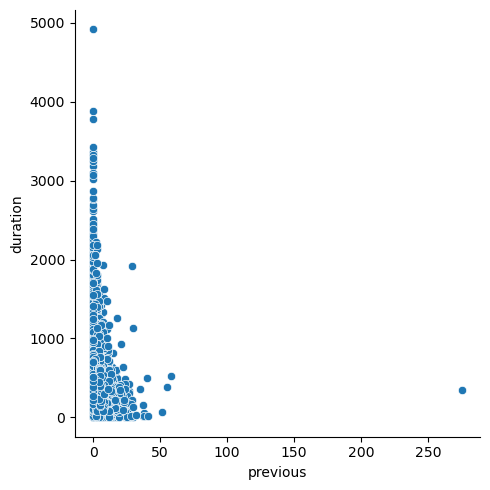

In [25]:
sns.relplot(data=df, x="previous", y="duration")
plt.show()

16 - poutcome: исход предыдущей маркетинговой компании (categorical: 'failure','nonexistent','success')

In [26]:
df['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

Объединим значения unkown и other

In [27]:
df['poutcome'] = df['poutcome'].replace('other', 'unknown')
df['poutcome'].value_counts()

unknown    38799
failure     4901
success     1511
Name: poutcome, dtype: int64

### Целевая переменная

17 - y Подписал ли клиент срочный вклад? (binary: 'yes','no')

In [28]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [29]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})
df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

## Влияние признаков

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [31]:
for col in ['default', 'housing', 'loan']:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [32]:
df_num_features = df.select_dtypes('int64')
df_num_features.drop('y', axis=1, inplace=True)
df_num_features.head(2)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
0,58,0,2143,1,0,5,261,1,-1,0
1,44,0,29,1,0,5,151,1,-1,0


In [33]:
df_cat_features = df.select_dtypes('object')
df_cat_features.head(2)

,job,marital,education,contact,month,poutcome
0,management,married,tertiary,unknown,may,unknown
1,technician,single,secondary,unknown,may,unknown


In [34]:
for col in df_cat_features.columns:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)

df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success,poutcome_unknown
0,58,management,married,tertiary,0,2143,1,0,unknown,5,...,0,0,0,1,0,0,0,0,0,1
1,44,technician,single,secondary,0,29,1,0,unknown,5,...,0,0,0,1,0,0,0,0,0,1


In [35]:
features = df.columns
features

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [36]:
selected_features = ['age', 'default', 'balance', 'housing',
       'loan', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_success', 'poutcome_unknown']

In [37]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['y'], random_state=42)

In [38]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [39]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'y')
    
df_balanced['y'].value_counts()

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0    29972
1    27552
Name: y, dtype: int64

In [40]:
X_train = df_balanced.drop(columns='y')
y_train = df_balanced['y']

In [41]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


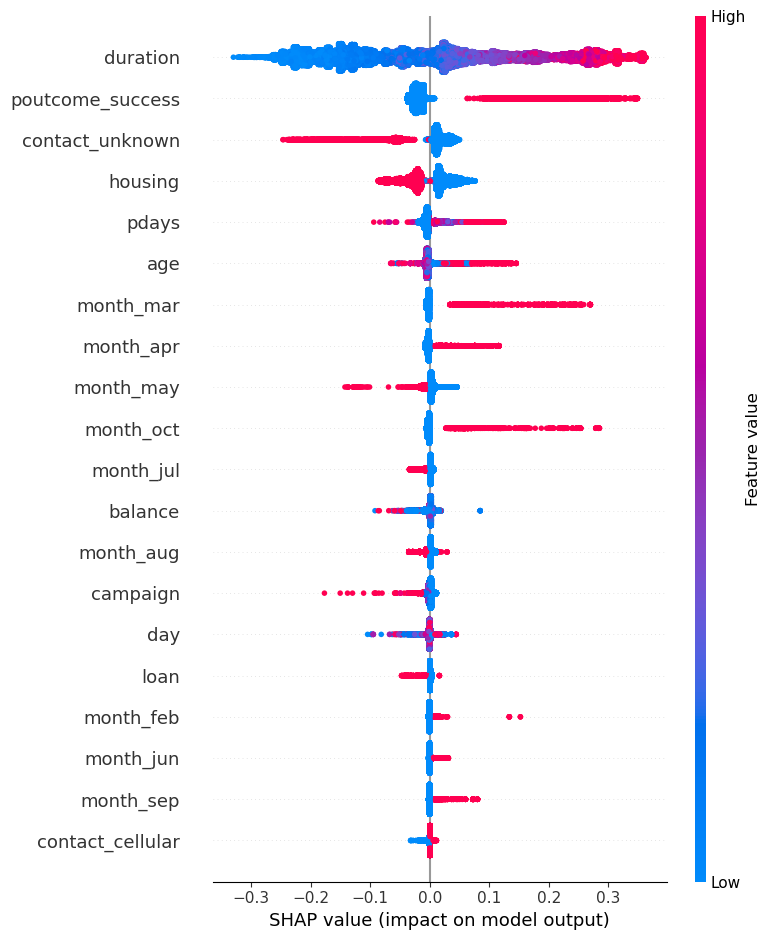

In [42]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X_train)

Самым влиятельным признаком оказался duration (длительность разговора), затем идет признак poutcome_success (успех предыдущей компании)

Подытожем всё вышеописанное и соберем пайплайн для нашей модели

In [43]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [44]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Отберем важные признаки

In [45]:
categorical_features = ['poutcome', 'contact']
numeric_features = ['duration']

In [46]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [47]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    


In [48]:
final_transformers = list()

for cat_col in categorical_features:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in numeric_features:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


In [49]:
# объединим в единынй пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [50]:
def get_classification_report(y_test, y_score, b=1):

    """
    Функция для оценки качества модели

    """
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(
        y_test, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    print(f'ROC_AUC score is: {roc_auc_score(y_test, y_score)}')
    return {'fscore': fscore[ix], 'precision': precision[ix],
            'recall': recall[ix], 'roc_auc_score': roc_auc_score(y_test, y_score)}

In [51]:
#разделим данные на train/val/test
X_train, X_other, y_train, y_other = train_test_split(df, df['y'], random_state=15, train_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, random_state=20, train_size=0.5)

In [52]:
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

#to json
X_test.to_json('X_test.json')

In [53]:
df_balanced = balance_df_by_target(df, 'y')
df_balanced['y'].value_counts()

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0    39922
1    37023
Name: y, dtype: int64

In [54]:
X_train = df_balanced.drop(columns='y')
y_train = df_balanced['y']

In [55]:
def ML_algorithm(ML_function):
    classifier = Pipeline([
        ('features',feats),
        ('classifier', ML_function),
    ])

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_val)[:, 1]
    y_test_pred = classifier.predict(X_val)
    results = {'y_score': y_score, 'y_test_pred': y_test_pred, 'classifier': classifier}
    return results

In [56]:
lightGBM = ML_algorithm(ML_function=lgbm.LGBMClassifier(random_state=42))

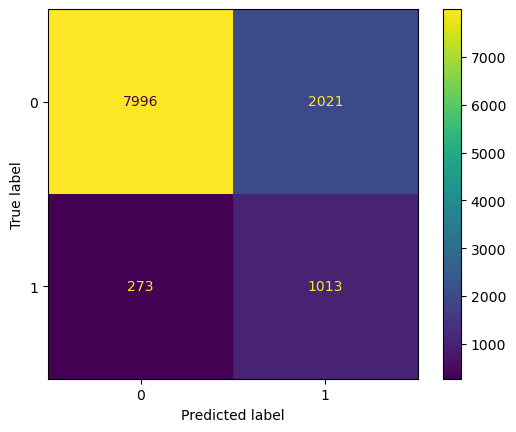

In [57]:
ConfusionMatrixDisplay.from_estimator(lightGBM['classifier'], X_val, y_val)
plt.show()

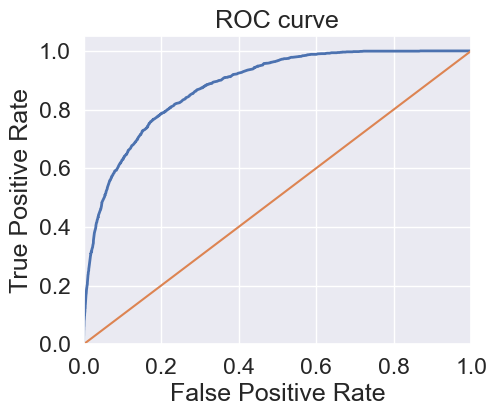

Best Threshold=0.731459, F-Score=0.537, Precision=0.517, Recall=0.558
ROC_AUC score is: 0.8812722881210806


In [58]:
lightGBM_report = get_classification_report(y_test=np.array(y_val),
                        y_score=lightGBM['y_score'])
plt.show()

In [59]:
CatBoost = ML_algorithm(ML_function=catb.CatBoostClassifier(silent=True, random_state=21))

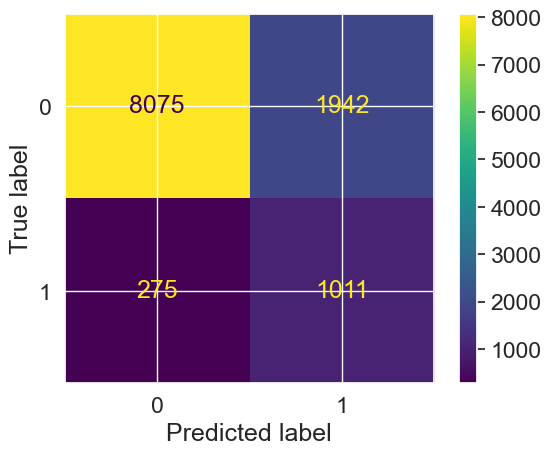

In [60]:
ConfusionMatrixDisplay.from_estimator(CatBoost['classifier'], X_val, y_val)
plt.show()

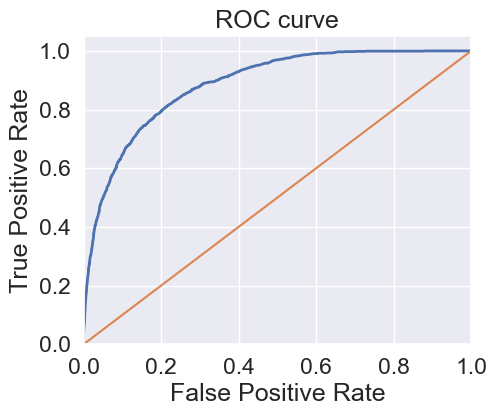

Best Threshold=0.687194, F-Score=0.538, Precision=0.476, Recall=0.618
ROC_AUC score is: 0.8859862029262541


In [61]:
CatBoost_report = get_classification_report(y_test=np.array(y_val),
                        y_score=CatBoost['y_score'])
plt.show()

In [62]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', catb.CatBoostClassifier(silent=True, random_state=21)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('poutcome',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='poutcome')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='poutcome'))])),
                                                ('contact',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='contact')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='contact'))])),
                                                ('duration',
                                                 Pipeline(steps=[('selector',
         

In [63]:
y_test_pred = pipeline.predict(X_test)

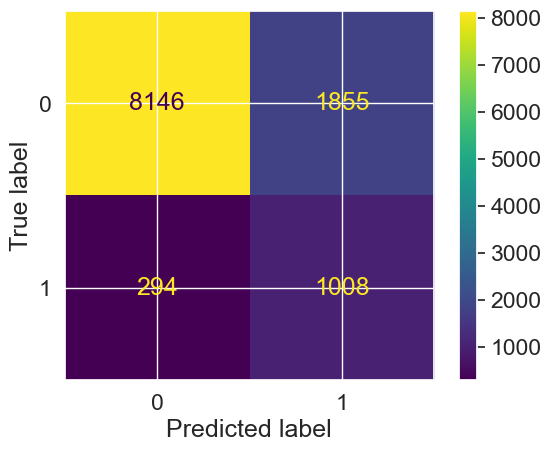

In [64]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

In [65]:
with open("catboost_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df['y'], test_size=0.33, random_state=42)
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)